In [19]:
import tensorflow as tf
from PIL import Image
from keras import preprocessing
import os
import keras
import tensorflow.python.keras.optimizers 
import numpy as np
import os
import PIL
import glob
import pathlib
from keras import layers
from sklearn.utils import class_weight


In [21]:
im = Image.open(r"data/faces/00001.jpg")

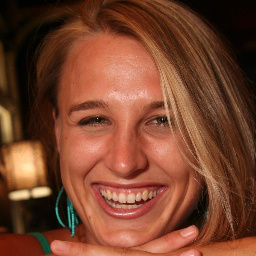

In [22]:
im.show()

In [23]:
print(im.format) 

print(im.mode)

print(im.size) 

print(im.palette) 

JPEG
RGB
(256, 256)
None


In [25]:
im2 = Image.open('data/animals/flickr_cat_000002.jpg')

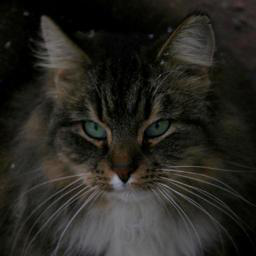

In [26]:
im2

In [27]:
print(im2.format)

print(im2.mode) 

print(im2.size) 

print(im2.palette) 

JPEG
RGB
(256, 256)
None


In [28]:
animals = []
# labels = []

for f in glob.glob("data/animals/*"):
    animals.append(os.path.relpath(f))
    
#     labels.append(0)

In [29]:
faces = []

for f in glob.glob("data/faces/*"):
    faces.append(os.path.relpath(f))
#     labels.append(1)

In [30]:
x = animals + faces
# y = labels

In [31]:
shuffle_array = x.copy()

In [32]:
np.random.shuffle(shuffle_array)

x_train = shuffle_array[:int(0.7 * len(shuffle_array))]
x_val = shuffle_array[int(0.7 * len(shuffle_array)):]

In [33]:
def load(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
#     img = tf.image.resize(img, size=(256, 256))
    label = tf.strings.split(file_path, os.sep)[1]
    label = tf.cast(tf.equal(label, 'faces'), tf.int32)
    return img, label

In [35]:
train_ds = tf.data.Dataset.from_tensor_slices(x_train).map(load).batch(32)

In [36]:
val_ds = tf.data.Dataset.from_tensor_slices(x_val).map(load).batch(32)

In [37]:
for x, y in train_ds.take(1):
    print(x, y)

tf.Tensor(
[[[[0.44705886 0.33333334 0.2627451 ]
   [0.43529415 0.32156864 0.2509804 ]
   [0.4156863  0.3019608  0.23137257]
   ...
   [0.8196079  0.6509804  0.6862745 ]
   [0.8235295  0.64705884 0.6745098 ]
   [0.8196079  0.6431373  0.67058825]]

  [[0.43921572 0.3254902  0.25490198]
   [0.427451   0.3137255  0.24313727]
   [0.40784317 0.29411766 0.22352943]
   ...
   [0.8196079  0.6431373  0.67058825]
   [0.8117648  0.63529414 0.6627451 ]
   [0.8078432  0.6313726  0.65882355]]

  [[0.43529415 0.32156864 0.2509804 ]
   [0.42352945 0.30980393 0.2392157 ]
   [0.40000004 0.28627452 0.21568629]
   ...
   [0.8078432  0.62352943 0.654902  ]
   [0.80392164 0.61960787 0.6509804 ]
   [0.8000001  0.6156863  0.6392157 ]]

  ...

  [[0.5411765  0.46274513 0.49803925]
   [0.5411765  0.46274513 0.49803925]
   [0.5411765  0.46274513 0.49803925]
   ...
   [0.5647059  0.2627451  0.09803922]
   [0.5686275  0.26666668 0.10196079]
   [0.5686275  0.26666668 0.10196079]]

  [[0.54901963 0.47058827 0.505882

2021-08-31 16:51:16.573411: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [38]:
for x, y in val_ds.take(1):
    print(x, y)

tf.Tensor(
[[[[0.3254902  0.2901961  0.25490198]
   [0.25882354 0.22352943 0.18823531]
   [0.454902   0.4156863  0.3803922 ]
   ...
   [0.654902   0.7725491  0.7803922 ]
   [0.65882355 0.77647066 0.7843138 ]
   [0.65882355 0.77647066 0.7843138 ]]

  [[0.18431373 0.14901961 0.1137255 ]
   [0.1764706  0.14117648 0.10588236]
   [0.32156864 0.28235295 0.24705884]
   ...
   [0.64705884 0.76470596 0.7725491 ]
   [0.6509804  0.7686275  0.77647066]
   [0.654902   0.7725491  0.7803922 ]]

  [[0.2627451  0.227451   0.20000002]
   [0.23529413 0.20000002 0.16470589]
   [0.2392157  0.20000002 0.16470589]
   ...
   [0.654902   0.76470596 0.77647066]
   [0.6509804  0.7686275  0.77647066]
   [0.6509804  0.7686275  0.77647066]]

  ...

  [[0.05882353 0.08235294 0.14509805]
   [0.14117648 0.16470589 0.227451  ]
   [0.10588236 0.11764707 0.18431373]
   ...
   [0.6313726  0.5294118  0.43137258]
   [0.6117647  0.5176471  0.4156863 ]
   [0.59607846 0.5019608  0.40000004]]

  [[0.07450981 0.09803922 0.152941

In [45]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [68]:
model = tf.keras.models.Sequential([
tf.keras.layers.Rescaling(1./255, input_shape=(256, 256, 3)),
# Note the input shape is the desired size of the image 256x256 with 3 bytes color
# This is the first convolution
tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 3)),
tf.keras.layers.MaxPooling2D(2, 2),
# The second convolution
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# The third convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# The fourth convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# # The fifth convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# Flatten the results to feed into a DNN
tf.keras.layers.Flatten(),
# 512 neuron hidden layer
tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
layers.Dropout(0.25),
# Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class and 1 for the other 
tf.keras.layers.Dense(1, activation='sigmoid')])

In [69]:
model.compile(loss='binary_crossentropy',
optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
metrics='accuracy')

In [56]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y),
                                                 np.array(y))

class_weight={0: class_weights[0], 1: class_weights[1]}

In [70]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=10,
    epochs=10,
    validation_steps=10,
    class_weight=class_weight
)

Epoch 1/10


2021-08-31 17:14:31.167101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 344 of 1000
2021-08-31 17:14:41.013961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 514 of 1000
2021-08-31 17:14:51.000127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 685 of 1000
2021-08-31 17:15:01.002932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 826 of 1000
2021-08-31 17:15:10.996010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 955 of 1000
2021-08-31 17:15:13.925166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


10/10 [==============================] - 67s 1s/step - loss: 0.7088 - accuracy: 0.7531 - val_loss: 0.6183 - val_accuracy: 0.7656
Epoch 2/10
10/10 [==============================] - 10s 1s/step - loss: 0.6222 - accuracy: 0.8156 - val_loss: 0.5901 - val_accuracy: 0.7656
Epoch 3/10
10/10 [==============================] - 10s 1s/step - loss: 0.6731 - accuracy: 0.7656 - val_loss: 0.6718 - val_accuracy: 0.7656
Epoch 4/10
10/10 [==============================] - 10s 981ms/step - loss: 0.5890 - accuracy: 0.8375 - val_loss: 0.6042 - val_accuracy: 0.7656
Epoch 5/10
10/10 [==============================] - 10s 996ms/step - loss: 0.5855 - accuracy: 0.8344 - val_loss: 0.6092 - val_accuracy: 0.7656
Epoch 6/10
10/10 [==============================] - 10s 992ms/step - loss: 0.6133 - accuracy: 0.8062 - val_loss: 0.5987 - val_accuracy: 0.7656
Epoch 7/10
10/10 [==============================] - 10s 1s/step - loss: 0.5879 - accuracy: 0.8313 - val_loss: 0.5980 - val_accuracy: 0.7656
Epoch 8/10
10/10 [====

In [73]:
model.save('CNN_face_detector')

INFO:tensorflow:Assets written to: CNN_face_detector/assets
